In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pyfaidx
from collections import Counter, defaultdict, OrderedDict
import logomaker
from copy import deepcopy
from tqdm import tqdm
from tqdm import tnrange
import deepdish
import pyBigWig
import tqdm
import sys
import pyfaidx
import pysam
sys.path.append("../../../chrombpnet/")
from training.utils.losses import multinomial_nll
from training.utils.one_hot import dna_to_one_hot
from evaluation.interpret.shap_utils import *
import matplotlib as plt
plt.rc('figure', max_open_warning = 0)
import seaborn as sns
import shap
import glob
tf.compat.v1.disable_eager_execution()
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import sklearn.cluster
from scipy.stats import chi2_contingency
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import pyBigWig
import matplotlib
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import sys
sys.path.append("../../../src/")
custom_objects={"tf":tf, "multinomial_nll":multinomial_nll}    
get_custom_objects().update(custom_objects)
from tensorflow import keras
#import proplot as pplt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
import timeit

In [7]:
### This function is to calculate unfiltered
def unfiltered_count_co_occurrences(peak_hit_counts):
    """
    From an N x M (peaks by motifs) array of hit counts, returns
    an M x M array of counts (i.e. how many times two motifs occur
    together in the same peak). For the diagonal entries, we require
    that motif occur at least twice in a peak to be counted.
    """
    peak_hit_indicators = (peak_hit_counts > 0).astype(int)
    num_motifs = peak_hit_indicators.shape[1]
    count_matrix = np.zeros((num_motifs, num_motifs), dtype=int)
    for i in range(num_motifs):
        for j in range(i):
            pair_col = np.sum(peak_hit_indicators[:, [i, j]], axis=1)
            count = np.sum(pair_col == 2)
            count_matrix[i, j] = count
            count_matrix[j, i] = count
        count_matrix[i, i] = np.sum(peak_hit_counts[:, i] >= 2)
    return count_matrix

In [2]:
def motifs_nonoverlap(motif1, motif2):
    return motif1['end'] - motif2['start'] < 3 or motif2['end'] - motif1['start'] < 3
def count_co_occurrences(df):
    co_occurrences_count_per_peak = defaultdict(lambda: defaultdict(int))

    grouped_df = df.groupby('peak')

    for group_name, group_df in grouped_df:
        n = len(group_df)

        for i in range(n):
            for j in range(i + 1, n):
                motif1 = group_df.iloc[i]
                motif2 = group_df.iloc[j]

                if motif1['key'] != motif2['key'] and motifs_nonoverlap(motif1, motif2):
                    mpair = tuple(sorted((motif1['key'], motif2['key'])))  # Make a tuple of sorted keys to ensure consistent counting
                    co_occurrences_count_per_peak[mpair][group_name] += 1
                    #print(f"Co-occurrence: {motif1['key']} at {motif1['peak']} with {motif1['start']} - {motif1['end']} and {motif2['key']} at {motif2['peak']} with {motif2['start']} - {motif2['end']}")

                if motif1['key'] == motif2['key']:
                    mpair = tuple(sorted((motif1['key'], motif2['key'])))  # Make a tuple of sorted keys to ensure consistent counting
                    co_occurrences_count_per_peak[mpair][group_name] += 1
                    #print(f"Co-occurrence: {motif1['key']} at {motif1['peak']} with {motif1['start']} - {motif1['end']} and {motif2['key']} at {motif2['peak']} with {motif2['start']} - {motif2['end']}")


    # Now we need to collapse the nested dictionaries to return only the frequencies
    # of group names for each motif pair
    result = defaultdict(dict)
    for motif_pair, peak_counts in co_occurrences_count_per_peak.items():
        for peak, count in peak_counts.items():
            result[motif_pair][peak] = count

    return result

In [9]:
lst_keys =[]
lst_values = []
with open('./motif_clustering_data/all_motif_clusters.annot.meme', 'r') as f:
    for l in f.readlines():
            if l.startswith("MOTIF"):
                l = l.split()[-1].split(' ')[0]
                lst_values.append(l)
                l = l.split()[-1].split('|')[0]
                lst_keys.append(l)

res = {lst_keys[i]: lst_values[i] for i in range(len(lst_keys))}

In [11]:
def check_motif_within_peak(motif_start, motif_end, peak_start, peak_end):
    return peak_start <= motif_start <= motif_end <= peak_end

In [18]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [21]:
#cmap1 = pplt.Colormap('Blues7_r', 'Reds', name='Diverging', save=True)
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list( 'custom',plt.get_cmap('Reds')(np.linspace(0,1,100)**(2)) )
custom_cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list( '',['white',*plt.cm.Reds((np.linspace(0,1,100)**(2)))])

## Hydra and Nematostella cooccurrence

In [3]:
NV_hydra_shared = ['JC_0062|PLAG1(0.000)','JC_0255|POU4F3(0.087)','JC_0283|TFAP2C(var.3)(0.009)','WC_1527|ASCL1(var.2)(6.131)',
                    'WC_2044|ASCL1(var.2)(7.196)','JC_0029|NR1I2(0.361)', 'JC_0047|Dlx2(0.053)', 'JC_0193|BACH1(0.087)', 
                    'JC_0218|MSC(0.281)', 'JC_0232|ZEB1(0.171)', 'JC_0250|HNF1B(0.014)', 'JC_0268|ZBED1(0.000)', 
                    'JC_0282|TFAP2A(0.165)', 'JC_0372|NHLH2(0.040)', 'WC_0107|ERF069(0.693)', 'WC_0323|ZBTB32(4.408)', 'WC_0910|ZHD6(4.269)', 
                    'WC_0917|SIX2(3.659)', 'WC_1065|MBP1(0.583)', 'WC_1219|TFAP4(0.410)', 'WC_1294|MYOG(0.992)',
                    'WC_1352|MYOG(0.909)', 'WC_1464|AT3G10030(6.098)', 'WC_1795|Ascl2(5.571)', 'WC_1913|bHLH18(3.642)']

In [8]:
### We want motif and peak file
NV_motif = pd.read_csv("./ChromBPNet/Motif_filtration/Nv/NV_peak_Motifhits_ELAV_positive_filtered_selfcooccur.tsv", sep="\t")
hydra_motif = pd.read_csv("./ChromBPNet/Motif_filtration/Hv/hydra_peak_Motifhits_PN_nGreen_filtered_selfcooccur.tsv", sep="\t")
NV_motif['peak'] = NV_motif['peak_chrom']+":"+ (NV_motif['peak_start']).astype(str) + "-" + NV_motif['peak_end'].astype(str)
hydra_motif['peak'] = hydra_motif['peak_chrom']+":"+ (hydra_motif['peak_start']).astype(str) + "-" + hydra_motif['peak_end'].astype(str)

NV_peak1 = pd.read_csv("./ChromBPNet/Peaks/ELAVP_ELAVN.DG.up.csv")
NV_peak2 = pd.read_csv("./ChromBPNet/Peaks/ELAVP_whole.DG.up.csv")
hydra_peak1 = pd.read_csv("./ChromBPNet/Peaks/nGreen_PN.DG.up.csv")
hydra_peak2 = pd.read_csv("./ChromBPNet/Peaks/PN_AEPwhole.DG.up.csv")

NV_peak1['peak'] = NV_peak1['Chr_ID']+':'+NV_peak1['Start'].astype(str)+'-'+NV_peak1['End'].astype(str)
NV_peak2['peak'] = NV_peak2['Chr_ID']+':'+NV_peak2['Start'].astype(str)+'-'+NV_peak2['End'].astype(str)
hydra_peak1['peak'] = hydra_peak1['Chr_ID']+':'+hydra_peak1['Start'].astype(str)+'-'+hydra_peak1['End'].astype(str)
hydra_peak2['peak'] = hydra_peak2['Chr_ID']+':'+hydra_peak2['Start'].astype(str)+'-'+hydra_peak2['End'].astype(str)
NV_peak_merged = pd.concat([NV_peak1,NV_peak2],axis=0)
hydra_peak_merged = pd.concat([hydra_peak1,hydra_peak2],axis=0)
NV_peak_merged = NV_peak_merged.groupby('peak', group_keys=False).apply(lambda x: x.loc[x.logFC.idxmax()])
hydra_peak_merged = hydra_peak_merged.groupby('peak', group_keys=False).apply(lambda x: x.loc[x.logFC.idxmax()])
NV_peak_map = pd.read_csv("./ChromBPNet/Peaks/NV_peaks_map.bed",sep="\t",header=None)
NV_peak_map.columns = ['chrom1','start1','end1','X','Y','Z','chrom2','start2','end2']
NV_peak_map['peak'] = NV_peak_map['chrom1']+":"+ (NV_peak_map['start1']).astype(str) + "-" + NV_peak_map['end1'].astype(str)
NV_peak_map['peak2'] = NV_peak_map['chrom2']+":"+ (NV_peak_map['start2']).astype(str) + "-" + NV_peak_map['end2'].astype(str)

## Need to map coordinate as diffbind output shift the peak coordinates 
hydra_peak_map = pd.read_csv("./ChromBPNet/Peaks/hydra_peak_map.bed",sep="\t",header=None)
hydra_peak_map.columns = ['chrom1','start1','end1','X','Y','Z','chrom2','start2','end2']
hydra_peak_map['peak'] = hydra_peak_map['chrom1']+":"+ (hydra_peak_map['start1']).astype(str) + "-" + hydra_peak_map['end1'].astype(str)
hydra_peak_map['peak2'] = hydra_peak_map['chrom2']+":"+ (hydra_peak_map['start2']).astype(str) + "-" + hydra_peak_map['end2'].astype(str)

NV_peak_merged = NV_peak_merged.drop('peak',axis=1).reset_index()
NV_merged_df = pd.merge(NV_peak_merged, NV_peak_map, on='peak', how='left')

hydra_peak_merged = hydra_peak_merged.drop('peak',axis=1).reset_index()
hydra_merged_df = pd.merge(hydra_peak_merged, hydra_peak_map, on='peak', how='left')
hydra_merged_df = hydra_merged_df.sort_values(by='logFC',ascending=False).head(n=2900)

NV_peak = NV_merged_df.peak2.tolist()
hydra_peak = hydra_merged_df.peak2.tolist()
NV_motif = NV_motif[NV_motif.peak.isin(NV_peak)]
hydra_motif = hydra_motif[hydra_motif.peak.isin(hydra_peak)]
NV_sub= NV_motif[["peak", "start","end","key"]]
hydra_sub = hydra_motif[["peak", "start","end","key"]]

In [20]:
### Unfiltered cooccurence, what I need is an input of peakxmotif matrix 
NV_sub_table = NV_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
NV_sub_counts = NV_sub_table.to_numpy()

hydra_sub_table = hydra_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
hydra_sub_counts = hydra_sub_table.to_numpy()

unfiltered_NV = unfiltered_count_co_occurrences(NV_sub_counts)
unfiltered_NV = pd.DataFrame(unfiltered_NV)
unfiltered_NV.index = NV_sub_table.columns.tolist()
unfiltered_NV.columns = NV_sub_table.columns.tolist()

unfiltered_hydra = unfiltered_count_co_occurrences(hydra_sub_counts)
unfiltered_hydra = pd.DataFrame(unfiltered_hydra)
unfiltered_hydra.index = hydra_sub_table.columns.tolist()
unfiltered_hydra.columns = hydra_sub_table.columns.tolist()

## UnFiltered_NV
co_occurrences_df = unfiltered_NV
motif_list = list(co_occurrences_df.columns)
NV_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
NV_long.columns = ['motif_1','motif_2','Num_Peaks']
NV_l1 = NV_long[NV_long["motif_1"].isin(NV_hydra_shared)]
NV_l1_l2 = NV_l1[NV_l1["motif_2"].isin(NV_hydra_shared)]
NV_unfiltered_n = pd.pivot(NV_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

## UnFiltered_hydra
co_occurrences_df = unfiltered_hydra
motif_list = list(co_occurrences_df.columns)
hydra_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
hydra_long.columns = ['motif_1','motif_2','Num_Peaks']
hydra_l1 = hydra_long[hydra_long["motif_1"].isin(NV_hydra_shared)]
hydra_l1_l2 = hydra_l1[hydra_l1["motif_2"].isin(NV_hydra_shared)]
hydra_unfiltered_n = pd.pivot(hydra_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

In [21]:
# Cooccurrence enrichment in NV 
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(NV_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=NV_sub['key'].unique(), columns=NV_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

NV_motif = NV_motif.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
NV_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
NV_long.columns = ['motif_1','motif_2','Num_Peaks']
NV_l1 = NV_long[NV_long["motif_1"].isin(NV_hydra_shared)]
NV_l1_l2 = NV_l1[NV_l1["motif_2"].isin(NV_hydra_shared)]
NV_filtered_n = pd.pivot(NV_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = NV_unfiltered_n.sub(NV_filtered_n)


for index,row in NV_filtered_n.iterrows():
    for motif in NV_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = NV_motif.loc[motif1].shape[0] -  delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = NV_motif.loc[motif2].shape[0] -  delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(NV_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        NV_filtered_n.at[index,motif] = frac
NV_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Nv/NV_cooccur_3_21_24_fixed.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

28.636076085998866 seconds


In [28]:
# Co-occurrence enrichment in hydra
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(hydra_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=hydra_sub['key'].unique(), columns=hydra_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

hydra_motif = hydra_motif.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
hydra_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
hydra_long.columns = ['motif_1','motif_2','Num_Peaks']
hydra_l1 = hydra_long[hydra_long["motif_1"].isin(NV_hydra_shared)]
hydra_l1_l2 = hydra_l1[hydra_l1["motif_2"].isin(NV_hydra_shared)]
hydra_filtered_n = pd.pivot(hydra_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = hydra_unfiltered_n.sub(hydra_filtered_n)

for index,row in hydra_filtered_n.iterrows():
    for motif in hydra_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = hydra_motif.loc[motif1].shape[0] - delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = hydra_motif.loc[motif2].shape[0] -  delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(hydra_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        hydra_filtered_n.at[index,motif] = frac
hydra_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Hv/hydra_cooccur_3_21_24_fixed.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

35.936782930000845 seconds


In [4]:
NV_plot = pd.read_csv("./ChromBPNet/Motif_filtration/Nv/NV_cooccur_3_21_24_fixed.tsv",sep="\t",index_col=0)
NV_plot['WC_0910|ZHD6(4.269)'] =1
NV_plot['WC_0917|SIX2(3.659)'] = 1
NV_plot['WC_1464|AT3G10030(6.098)']= 1

motif_notin = 'WC_0910|ZHD6(4.269)'
new_row = pd.Series(1, index=NV_plot.columns, name=motif_notin)
NV_plot = NV_plot.append(new_row)
motif_notin2 = 'WC_0917|SIX2(3.659)'
new_row = pd.Series(1, index=NV_plot.columns, name=motif_notin2)
NV_plot = NV_plot.append(new_row)
motif_notin3 ='WC_1464|AT3G10030(6.098)'
new_row = pd.Series(1, index=NV_plot.columns, name=motif_notin3)
NV_plot = NV_plot.append(new_row)
NV_plot = NV_plot.loc[NV_hydra_shared,NV_hydra_shared]

NV_plot_counts = NV_plot.to_numpy()

hydra_plot = pd.read_csv("./ChromBPNet/Motif_filtration/Hv/hydra_cooccur_3_21_24_fixed.tsv",sep="\t",index_col=0)
hydra_plot = hydra_plot.loc[NV_hydra_shared,NV_hydra_shared]
hydra_plot_counts = hydra_plot.to_numpy()

/tmp/ipykernel_5770/18796087.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NV_plot = NV_plot.append(new_row)
/tmp/ipykernel_5770/18796087.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NV_plot = NV_plot.append(new_row)
/tmp/ipykernel_5770/18796087.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NV_plot = NV_plot.append(new_row)


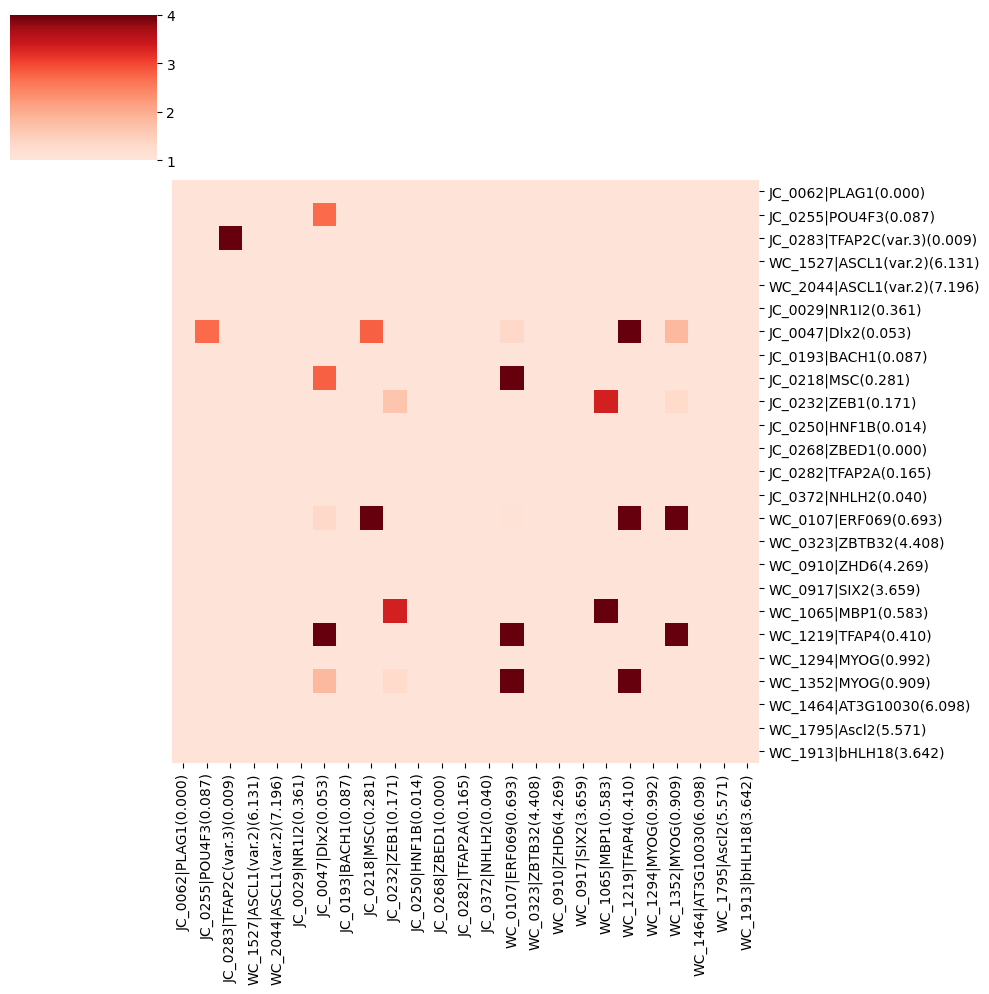

In [39]:
cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
NV_heatmap = sns.clustermap(NV_plot_counts,robust=True,cmap=custom_cmap,row_cluster=False,col_cluster=False,vmin=1,vmax=4,center=1.8,figsize=(10, 10),cbar_kws=cbar_kws)#,vmax=10)#row_linkage = zmuscle, col_linkage = zmuscle, robust=True,cmap='Blues',vmax=10)
NV_heatmap.ax_heatmap.set_xticks(np.arange(NV_plot_counts.shape[1])+0.5)
NV_heatmap.ax_heatmap.set_yticks(np.arange(NV_plot_counts.shape[0])+0.5)

NV_heatmap.ax_heatmap.set_xticklabels( NV_hydra_shared, rotation=90 ) 
NV_heatmap.ax_heatmap.set_yticklabels( NV_hydra_shared, rotation=0 ) 
plt.tight_layout()
plt.savefig("./Plots/EDFig9/PanelED9d_Nv.svg",format="svg")
plt.show()

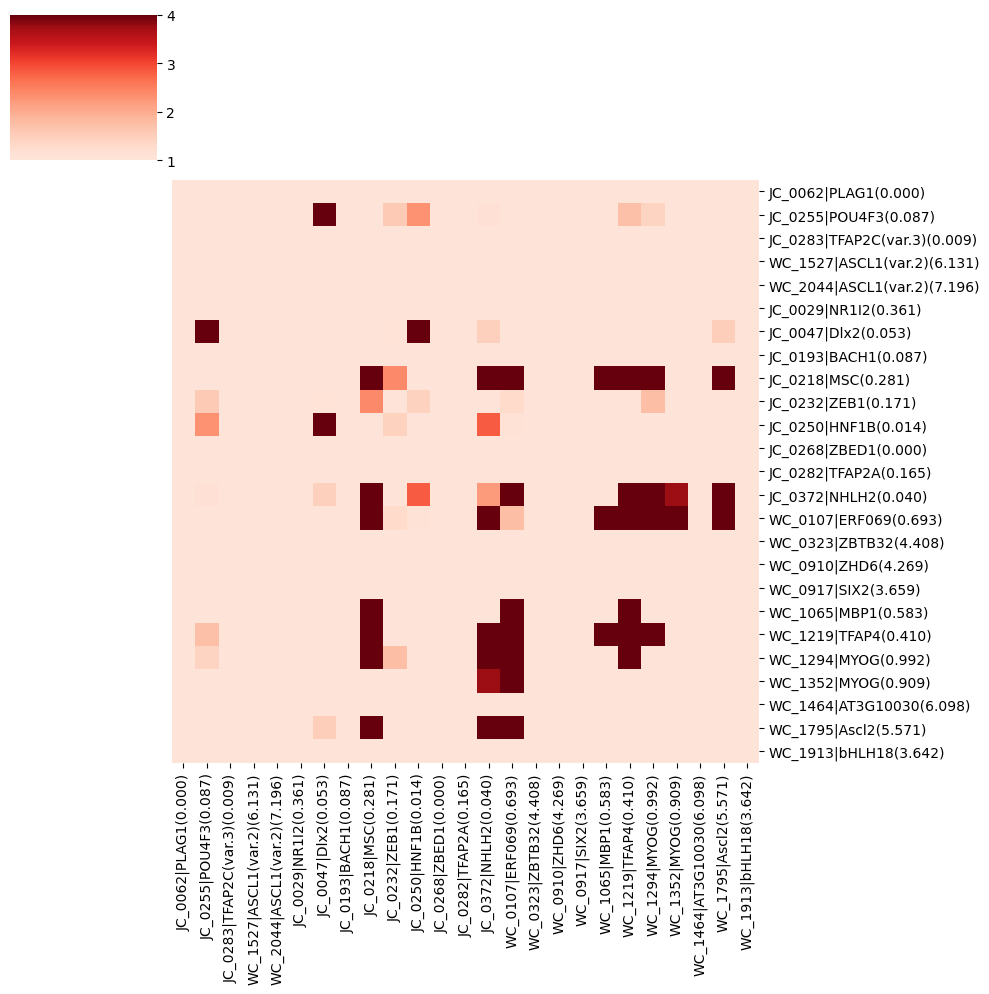

In [38]:
cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
hydra_heatmap = sns.clustermap(hydra_plot_counts,robust=True,cmap=custom_cmap,row_cluster=False,col_cluster=False,vmin=1,vmax=4,center=1.8,figsize=(10, 10),cbar_kws=cbar_kws)#,vmax=10)#row_linkage = zmuscle, col_linkage = zmuscle, robust=True,cmap='Blues',vmax=10)
hydra_heatmap.ax_heatmap.set_xticks(np.arange(hydra_plot_counts.shape[1])+0.5)
hydra_heatmap.ax_heatmap.set_yticks(np.arange(hydra_plot_counts.shape[0])+0.5)

hydra_heatmap.ax_heatmap.set_xticklabels( NV_hydra_shared, rotation=90 ) 
hydra_heatmap.ax_heatmap.set_yticklabels( NV_hydra_shared, rotation=0 ) 
plt.tight_layout()
plt.savefig("./Plots/EDFig9/PanelED9d_Hv.svg",format="svg")
plt.show()

In [28]:
min_merged = np.concatenate((NV_plot_counts[:,:,None],hydra_plot_counts[:,:,None]),axis=2).min(2)

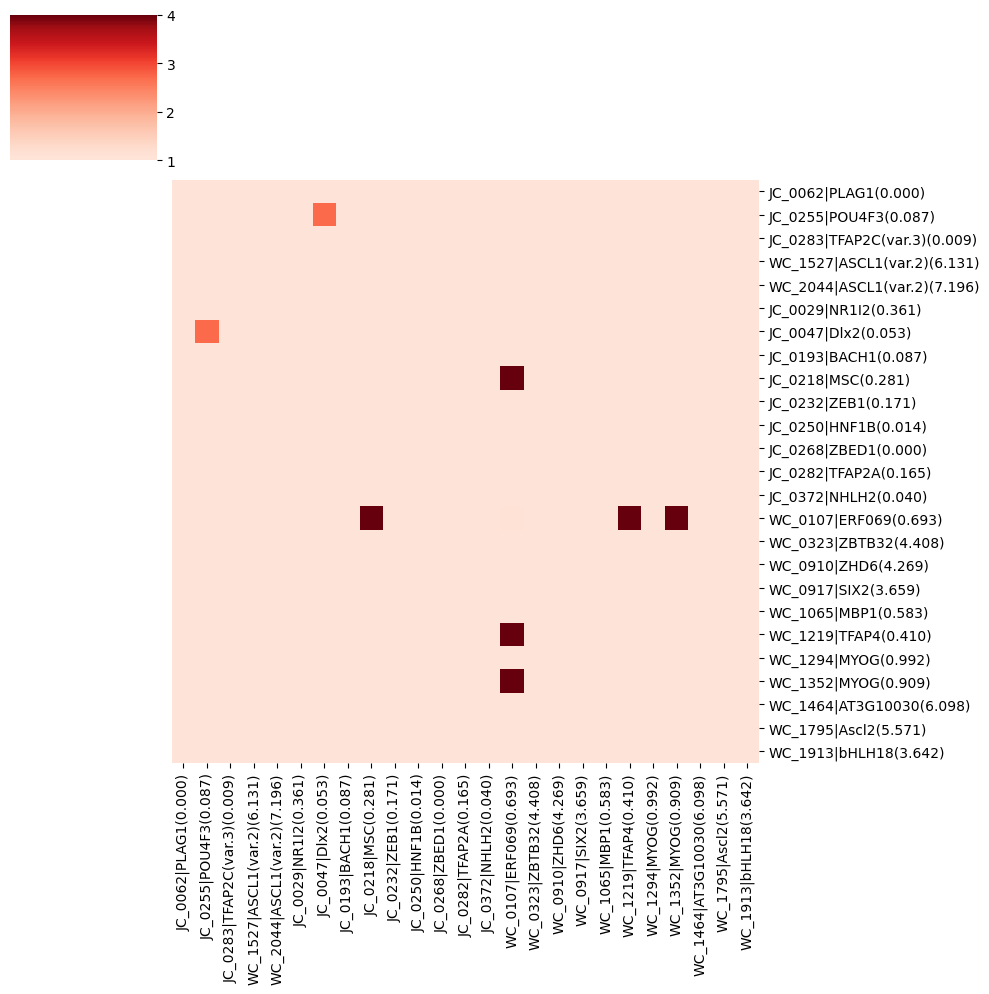

In [23]:
cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
minimum_heatmap = sns.clustermap(min_merged,robust=True,cmap=custom_cmap,row_cluster=False,col_cluster=False,vmin=1,vmax=4,center=1.8,figsize=(10, 10),cbar_kws=cbar_kws)#,vmax=10)#row_linkage = zmuscle, col_linkage = zmuscle, robust=True,cmap='Blues',vmax=10)
minimum_heatmap.ax_heatmap.set_xticks(np.arange(min_merged.shape[1])+0.5)
minimum_heatmap.ax_heatmap.set_yticks(np.arange(min_merged.shape[0])+0.5)

minimum_heatmap.ax_heatmap.set_xticklabels( NV_hydra_shared, rotation=90 ) 
minimum_heatmap.ax_heatmap.set_yticklabels( NV_hydra_shared, rotation=0 ) 
plt.tight_layout()
plt.savefig("./Plots/EDFig9/PanelED9d_minimum.svg",format="svg")
plt.show()